<a href="https://colab.research.google.com/github/sushanttwayana/ML-DL-Strategies-Toolkit/blob/main/classifying_images_from_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying images from Fashion MNIST using feedforward neural networks

Dataset source: https://github.com/zalandoresearch/fashion-mnist
Detailed tutorial: https://jovian.ml/aakashns/04-feedforward-nn

In [ ]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
project_name='fashion-feedforward-minimal'

## Preparing the Data

In [ ]:
dataset = FashionMNIST(root='data/', download=True, transform=ToTensor())
test_dataset = FashionMNIST(root='data/', train=False, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:04<00:00, 6027820.58it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300748.95it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5493521.74it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9792415.87it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size=128

In [ ]:
# DataLoader for the training dataset (train_ds):
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

# DataLoader for the validation dataset (val_ds):
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

# DataLoader for the test dataset (test_dataset):
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

* DataLoader is a PyTorch utility that helps in efficiently loading and iterating over data during training.
train_ds, val_ds, and test_dataset are assumed to be datasets containing your training, validation, and test data, respectively.

* batch_size: It specifies the number of samples in each mini-batch. The DataLoader will iterate over the dataset in batches of this size.

* shuffle=True: This means that the data will be shuffled at the beginning of each epoch during training. Shuffling helps in preventing the model from learning the order of the data.

* num_workers=4: It indicates the number of parallel data loading processes. Setting a number greater than 0 can speed up data loading by loading batches in parallel using multiple CPU cores.

* pin_memory=True: This option is used to speed up the transfer of data to the GPU. If pin_memory is set to True, the data loader will attempt to pin the data in memory, which can make data transfer to the GPU faster.

* In summary, these three lines of code are setting up data loaders for the training, validation, and test datasets with specific configurations to facilitate efficient training of a machine learning model.

In [ ]:
# Permute the dimensions to (height, width, channels)
print(images.permute((1, 2, 3, 0)))

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

images.shape: torch.Size([128, 1, 28, 28])


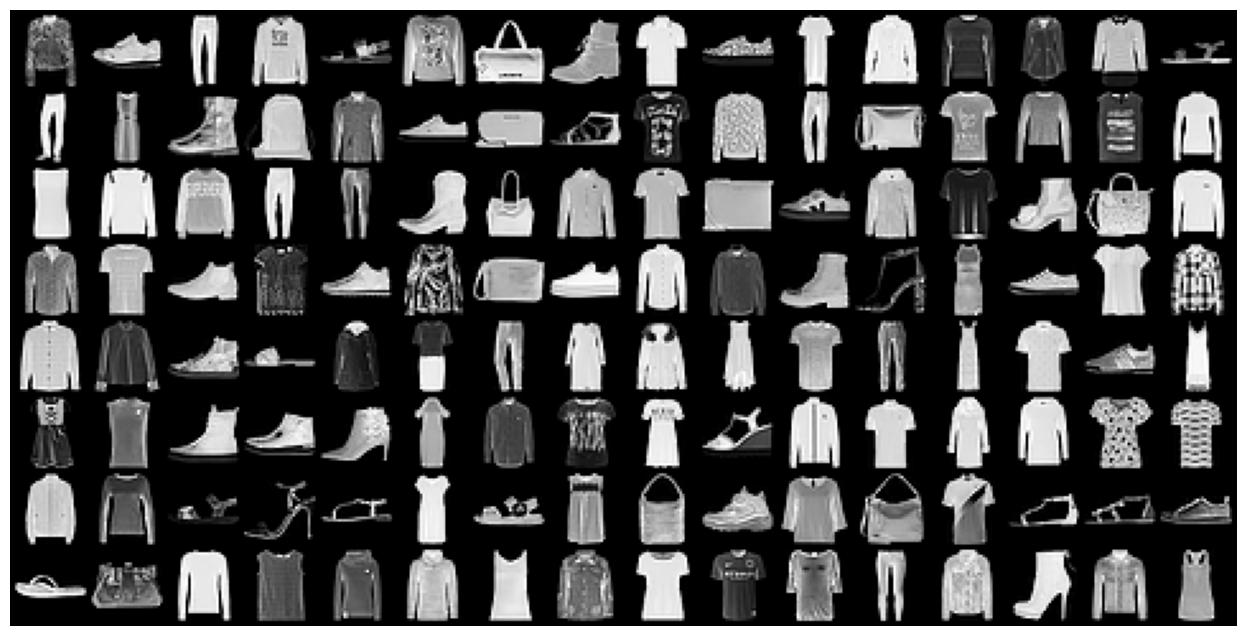

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 16)
        # hidden layer 2
        self.linear2 = nn.Linear(16, 32)
        # output layer
        self.linear3 = nn.Linear(32, out_size)

    def forward(self, xb):
        # Assuming xb is a tensor representing a batch of images
        # xb.size(0) gives the size of the first dimension, which is typically the batch size
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear3(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

## Using a GPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the model

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
input_size = 784
num_classes = 10

In [ ]:
model = MnistModel(input_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3138182163238525, 'val_acc': 0.16689452528953552}]

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5692, val_acc: 0.7825
Epoch [1], val_loss: 1.0033, val_acc: 0.6788
Epoch [2], val_loss: 0.6917, val_acc: 0.7569
Epoch [3], val_loss: 0.6386, val_acc: 0.7754
Epoch [4], val_loss: 0.4546, val_acc: 0.8417


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4347, val_acc: 0.8443
Epoch [1], val_loss: 0.4165, val_acc: 0.8479
Epoch [2], val_loss: 0.4167, val_acc: 0.8468
Epoch [3], val_loss: 0.4287, val_acc: 0.8442
Epoch [4], val_loss: 0.4140, val_acc: 0.8481


In [ ]:
history += fit(10, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4067, val_acc: 0.8521
Epoch [1], val_loss: 0.4056, val_acc: 0.8532
Epoch [2], val_loss: 0.4053, val_acc: 0.8512
Epoch [3], val_loss: 0.4062, val_acc: 0.8530
Epoch [4], val_loss: 0.4051, val_acc: 0.8528
Epoch [5], val_loss: 0.4052, val_acc: 0.8525
Epoch [6], val_loss: 0.4052, val_acc: 0.8540
Epoch [7], val_loss: 0.4049, val_acc: 0.8532
Epoch [8], val_loss: 0.4047, val_acc: 0.8527
Epoch [9], val_loss: 0.4050, val_acc: 0.8529


In [ ]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4041, val_acc: 0.8531
Epoch [1], val_loss: 0.4041, val_acc: 0.8533
Epoch [2], val_loss: 0.4040, val_acc: 0.8536
Epoch [3], val_loss: 0.4039, val_acc: 0.8534
Epoch [4], val_loss: 0.4039, val_acc: 0.8534
Epoch [5], val_loss: 0.4039, val_acc: 0.8531
Epoch [6], val_loss: 0.4039, val_acc: 0.8533
Epoch [7], val_loss: 0.4039, val_acc: 0.8535
Epoch [8], val_loss: 0.4039, val_acc: 0.8535
Epoch [9], val_loss: 0.4039, val_acc: 0.8533


In [ ]:
history += fit(5, 0.00001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4039, val_acc: 0.8533
Epoch [1], val_loss: 0.4039, val_acc: 0.8533
Epoch [2], val_loss: 0.4039, val_acc: 0.8533
Epoch [3], val_loss: 0.4039, val_acc: 0.8533
Epoch [4], val_loss: 0.4039, val_acc: 0.8533


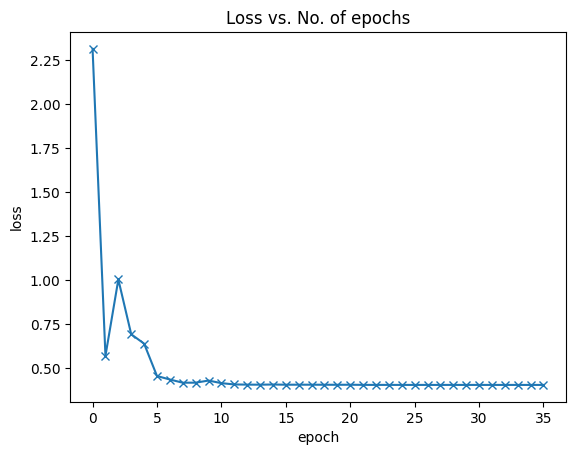

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

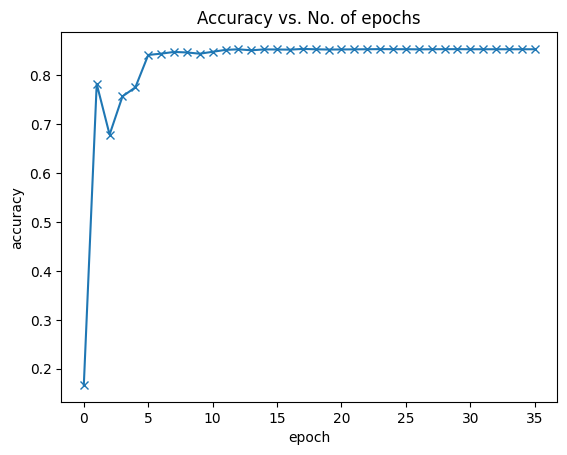

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Prediction on Samples

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Ankle boot , Predicted: Ankle boot


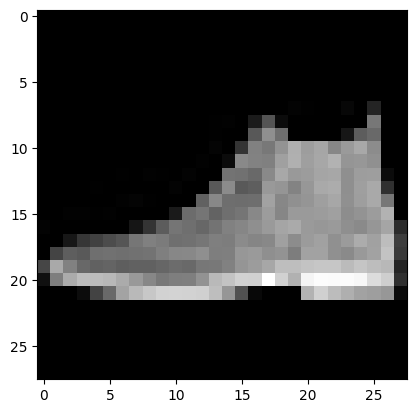

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: Coat , Predicted: Coat


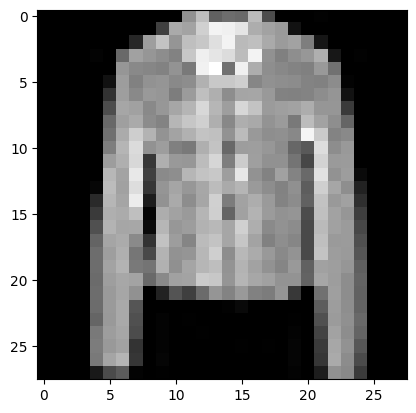

In [ ]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: T-shirt/top , Predicted: T-shirt/top


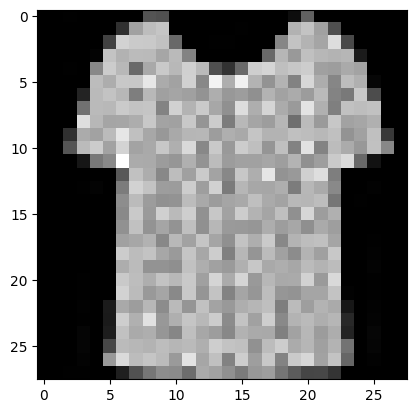

In [ ]:
img, label = test_dataset[1000]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

Label: Sandal , Predicted: Sandal


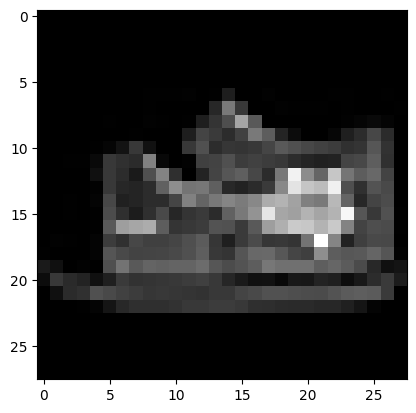

In [ ]:
img, label = test_dataset[9999]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [ ]:
evaluate(model, test_loader)

{'val_loss': 0.42337074875831604, 'val_acc': 0.847363293170929}

## Save and upload

In [ ]:
saved_weights_fname='fashion-feedforward.pth'

In [ ]:
torch.save(model.state_dict(), saved_weights_fname)